[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorial_notebooks/10_xai_solutions.ipynb)

# Tutorial 10 - Explainable AI (XAI)
<br>
<span style="font-weight: bold; color: red;">This version includes solutions to the exercises. </span>
<br>

So far, we have talked about model training, the evaluation of predictive accuracy, and, of course, different learning algorithms. In this notebook, we revisit our lecture on explainable AI (XA). Many potent models are complex, and thus their recommendations are hard to follow for humans. This is referred to as the interpretability vs. accuracy trade-off. 

Why does interpretability matter? When we decide whether someone receives a discount, making a wrong prediction entails low cost. However, when we talk about banks giving credits or refusing to do so, not to mention medical applications, the cost of an erroneous classification becomes much higher. Predictive accuracy, the perspective we emphasized when discussing model quality, remains useful but is often insufficient. To build trust, we need to demonstrate that model recommendations (e.g., predictions) are consistent with domain knowledge. Being able to explain the model-estimated feature-to-target relationship is the most important step. Even for predictive accuracy, understanding the feature-target relationship, which will determine predictions, is useful if not crucial. To see this, recall that we evaluate predictive accuracy on a test set, which is only a sample from the population. Say we have a model that predicts the test data highly accurately. Are we comfortable with believing that future data beyond the test set (sample) will be predicted with the same high degree of accuracy? Maybe, but typically we would want additional evidence. Knowing the way in which a model translates feature values into predictions and knowing that this translation is sensible brings the additional amount of comfort. Let's stress this point with a counterexample. Say you build a model to predict health risks. You would not trust a model that predicts health conditions to improve with excessive consumption of alcohol and junk food, smoking, deprivation of sleep, etc. We know these factors (i.e., feature values) are unhealthy and a model predicting, e.g., life expectation in years, must reflect this domain knowledge in its forecasts. Otherwise, no matter what test set accuracy might show, we would reject the model for not being plausible. This shows why understanding a model-estimated feature-to-target relationship is crucial. Beyond building trust, regulations might demand insight into models, for example in financial contexts, and thus rule out opaque models. In this notebook, we will look into different techniques that promise to explain the decisions of ML models and make the feature-to-target relationship interpretable.

The main topics include:
- Global explanations
    - Surrogate modeling
    - Permutation-based feature importance
    - Partial dependence plots (PDPs)
- Local explanations
    - Shapley Additive Explanations


## Preliminaries
As always, we start with importing some standard packages and loading our (credit) data. Further, we need some black-box models the predictions of which we aim at interpreting. The corresponding codes are well-known from previous sessions; no need for explanations. Just execute the below code cells. 

In [1]:
# Import standard packages. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

rnd_state = 888  # for reproducibility

# Loading and preparing the data
import bads_helper_functions as bads  # import module with bads helper functions
X, y = bads.get_HMEQ_credit_data()  # load the data 
print("Data preparation completed. Shape of X: ", X.shape, "Shape of y:", y.shape)

# Data partitioning
from sklearn.model_selection import train_test_split
ts_frac = 0.3  # 30% of the data as hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts_frac, random_state=rnd_state)  

Data preparation completed. Shape of X:  (5960, 18) Shape of y: (5960,)


Next we train a Random Forest (RF) classifier. RF is a complex - *opaque* - ML algorithm that often yields good performance. Since the model involves many base models, it is not at all clear how feature values and predictions related to another. Thus, RF is a good example for an approach that requires post-hoc xAI methods to explain forecasts.

In [2]:
#Fit a RF classifier and estimate the AUC score on the test set:
from sklearn.ensemble import RandomForestClassifier
# Train XGB model
rf = RandomForestClassifier(n_estimators=500, max_depth=15, random_state=rnd_state) 
rf.fit(X_train, y_train)

# Evaluate models
from sklearn.metrics import roc_auc_score
print('RF AUC is: {:.4}'.format(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])))

RF AUC is: 0.9517


# Global feature importance analysis
We begin with XAI methods that aim to explain a model as a whole. These methods are called global explanations. We will look at three different techniques: surrogate modeling, permutation-based feature importance, and partial dependence plots (PDPs).

## Surrogate modeling
Recall how we introduced the main idea of a surrogate modeling approach in the course. We build a simpler model that approximates the predictions of a complex model. This simpler model is easier to interpret and can be used to explain the complex model. In the following, we will build a surrogate model for the RF classifier we trained above.

<br>
<img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/xai_surrogate_model.png" width="854" height="480" alt="Surrogate model">

The idea is quite straightforward and so we make this an exercise for you. Specifically:

### Exercise 1
1. Compute training set predictions using the trained RandomForest `rf` and store the result in a variable `y_train_sg`. Note that we aim to explain a **classification model**. This has implications for the calculation of predictions...
2. Train a *suitable type regression model* using the original training set `X_train` and the RF training set predictions `y_train_sg` as new *surrogate* target. Recall, again, what we try to achieve with the surrogate model and let this understanding guide you in choosing the right regression model type.
3. Create a scatter plot of the true target values `y_train` against the surrogate model predictions `y_train_sg` and examine their agreement.
4. Obtain the $R^2$ score of the surrogate model on the training set. This score will give you an idea of how well the surrogate model approximates the RF model.
5. Visualize the regression coefficients using a bar. This plot is essentially your XAI output, the global explanation of the RF model using the linear regression surrogate model.




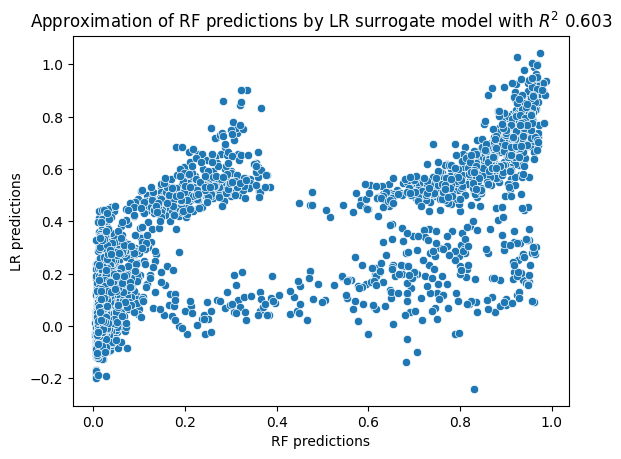

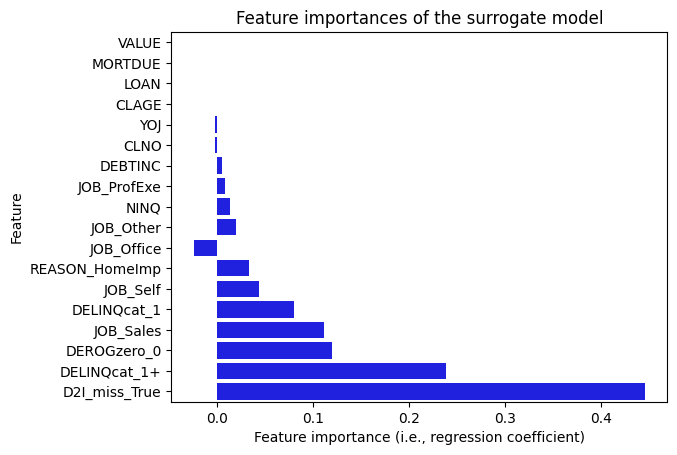

In [3]:
# Solution of Exercise 1
from sklearn.linear_model import LinearRegression  # RF predictions are probabilities, so we need a linear regression model; not a logistic regression model
y_train_sg = rf.predict_proba(X_train)[:,1]

lr = LinearRegression().fit(X=X_train, y=y_train_sg)  # Fit the linear regression model on the data for the surrogate model

# R2 score of the surrogate model
r2 = lr.score(X_train, y_train_sg)

# Scatter plot of RF versus surrogate model predictions
sns.scatterplot(x=y_train_sg, y=lr.predict(X_train))
plt.xlabel('RF predictions')
plt.ylabel('LR predictions')
plt.title(f'Approximation of RF predictions by LR surrogate model with $R^2$ {r2:.3f}')
plt.show()

# Bar plot of feature importances
# The exercise did not ask for it but it is useful to sort the features by 'importance' for better visualization
sort_idx = np.abs(lr.coef_).argsort()
sns.barplot(x=lr.coef_[sort_idx], y=X.columns[sort_idx], color='b') 
plt.xlabel('Feature importance (i.e., regression coefficient)')
plt.ylabel('Feature')
plt.title('Feature importances of the surrogate model')
plt.show()



## Permutation-based feature importance
Permutation-based feature importance is a learner-agnostic way to judge the relevance of features. It produces an ordinal feature ranking. To achieve this, the algorithm permutes one feature by shuffling its values across all observations. This means each observation will receive a new feature value. This permutation breaks the relationship to the target variable. In other words, a learner should no longer be able to use the information in the feature to predict the target. Permutation-based feature importance exploits this by comparing the predictive performance of a model before and after permuting a feature. The higher the increase of the prediction error due to the permutation, the more important the feature. Repeating the comparison of model performance before vs. after permutation for all features, we obtain a ranking of features. Let's demonstrate this for the RF classifier.
- First we import the necessary package `permutation_importance` from `sklearn.inspection`.
- Next, we compute the permutation-based feature importance for the RF classifier `rf` using the training data.
- Then, we sort the feature importance values in descending order for better readability.
- Finally, we visualize the feature importance using a bar plot.

In [4]:
# Import permutation-based feature importance from sklearn.inspection & apply the function to the fitted
# RF, pay attention to the score function and to the parameter n_repeats:
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(rf, X_test, y_test, random_state=rnd_state)  # note that this step can take a while

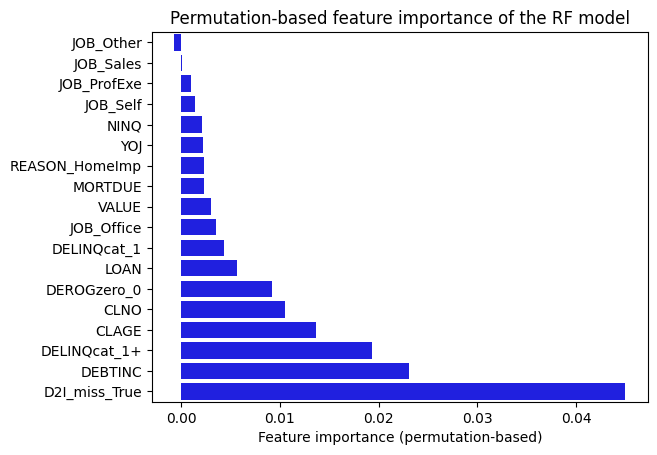

In [5]:
# Sort features in descending order based on the permutation importance scores:
sort_idx = perm_imp.importances_mean.argsort()

# Generate a bar-plot of RF feature importance:
sns.barplot(x=perm_imp.importances_mean[sort_idx], y=X.columns.values[sort_idx], color='b')
plt.xlabel('Feature importance (permutation-based)')
plt.title('Permutation-based feature importance of the RF model')
plt.show()

### Exercise 2
Recall how the values of the permutation-based feature importance are calculated. We compare the model performance before and after permuting a feature. The difference in performance is a measure of the feature importance. The larger the difference, the more important the feature. But what is the performance metric we use to compare the model performance? We did not specify it in the above demo, suggesting that some kind of default was used. 
- Check the documentation to find out which performance metric is used by default.
- Recompute the permutation-based feature importance using the `rf` model and the training data. This time, specify the performance metric to be the AUC. Make sure to store the result in a new variable to not overwrite the above importance values.

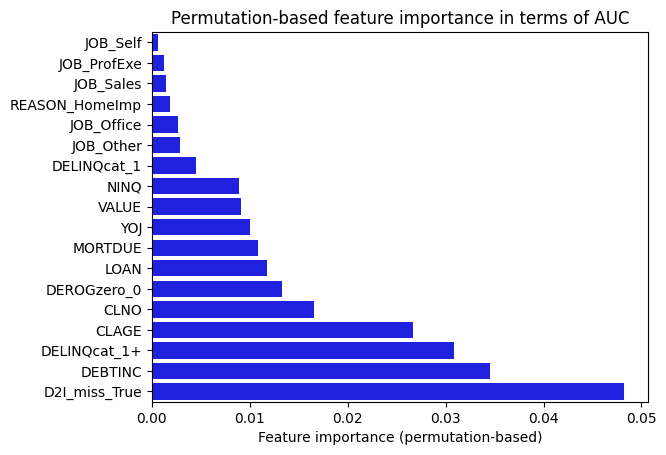

In [6]:
# Solution to Exercise 2
perm_imp2 = permutation_importance(rf, X_test, y_test, scoring='roc_auc', random_state=rnd_state)  # note that this step can take a while

# Sort features in descending order based on the permutation importance scores:
sort_idx = perm_imp2.importances_mean.argsort()

# Generate a bar-plot of RF feature importance:
sns.barplot(x=perm_imp2.importances_mean[sort_idx], y=X.columns.values[sort_idx], color='b')
plt.xlabel('Feature importance (permutation-based)')
plt.title('Permutation-based feature importance in terms of AUC')
plt.show()

### Exercise 3
We now have two rankings of feature importances, one using AUC and the other using the default metric selected by `permutation_importance`. Do these rankings agree? To which extent? 

One way to answer this is to compute the *rank correlation* between the two rankings. Popular ways to calculate the correlation between ranks include *Spearman's rank correlation* and *Kendall's rank correlation*. These coefficients are widely known as Spearman's $\rho$ or Kendall's $\tau$. Here, we will use the latter. An implementation is available in the `scipy` package and goes by the name `kendalltau`. Here is your task:

Examine the agreement between the two feature importance rankings by computing Kendall's rank correlation coefficient. What correlation do you observe and what is your interpretation?
You can also study the agreement between the permutation-based feature importance ranking and the ranking from the surrogate model.

In [7]:
# Rank correlation between the permutation-based feature importance and the surrogate model feature importance:
from scipy.stats import kendalltau

# Rank correlation between the permutation-based feature importance with AUC and default metric
tau, p_value = kendalltau(perm_imp.importances_mean, perm_imp2.importances_mean)
print(f'The Kendall rank correlation between the permutation-based feature importance rankings is {tau:.3f} with a p-value of {p_value:.3f}')

# Rank correlation between the permutation-based feature importance and the surrogate model feature importance:
tau, p_value = kendalltau(perm_imp.importances_mean, lr.coef_)
print(f'The Kendall rank correlation between the permutation-based feature importance ranking and the surrogate model ranking is {tau:.3f} with a p-value of {p_value:.3f}')

The Kendall rank correlation between the permutation-based feature importance rankings is 0.734 with a p-value of 0.000
The Kendall rank correlation between the permutation-based feature importance ranking and the surrogate model ranking is 0.013 with a p-value of 0.940


### Closing remarks and suggestions
Before moving on to other forms of xAI. Let's briefly discuss another - nicer - way to visualize the results of permutation-based feature importance analysis. You may have noticed that we used a field `perm_imp.importances_mean` in the above demos. The name of this field (i.e., the suffix  *_mean*) indicates that  the function `permutation_importance` repeats the calculation by default. This is one reason it took quite long. Since permutation is a stochastic operation, it makes sense to consider multiple random permutations of feature values. Perhaps you also spotted the argument `n_repeats` with default value of 5 in the function's documentation, which allows you to determine how many repetitions you want it to perform. 

Given that we have results from multiple (i.e., 5) repetitions available - you can access these via `perm_imp.importances` - we can also visualize the raw results by means of a boxplot. This way, we obtain more insight into, e.g., the robustness of the importance scores. Here is a demo. 

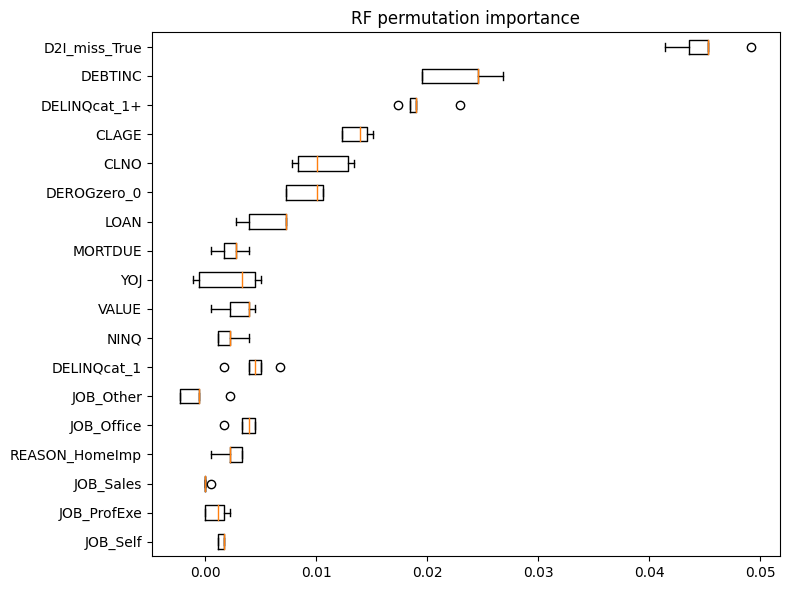

In [8]:
# Box plot of RF feature importance
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(perm_imp.importances[sort_idx].T,
           vert=False, labels=X.columns.values[sort_idx])
ax.set_title('RF permutation importance')
fig.tight_layout()
plt.show()


Lastly, while we considered the implementation of permutation-based feature importance in `sklearn`, there are other packages that offer this functionality. One of them is `eli5`, which is said to provide better visualizations and, more general, outputs that better address the XAI requirements of end users. You may want to explore this package on your own.

# Partial Dependence Analysis
A partial dependence plot (PDP) depicts the **marginal** effect of a feature on model predictions, and this complements permutation-based feature importance analysis. Remember that the latter is useful to understand on which features a model relies. Afterward, however, we still do not know whether higher/lower values of a feature lead to higher/lower predictions. For example, does the model-estimated default probability increase or decrease when the debt-to-income ratio increases? A PDP answers this question and is, therefore, a natural complement to permutation-based feature importance. A PDP plots the values of a focal feature (on the x-axis) against model predictions (on the y-axis) whilst accounting for the combined effect of all other features (hence marginal effect). This marginalization is basically achieved by examining the model prediction for each value of the focal variable while averaging the values for other variables. We refer to the lecture on interpretable machine learning for a more formal coverage of partial-dependence analysis. Here, we proceed with a demo and examine the partial dependence between the model-estimated probability of default and the feature LOAN. To achieve this, we use the class `PartialDependenceDisplay` from  `sklearn.inspection`.

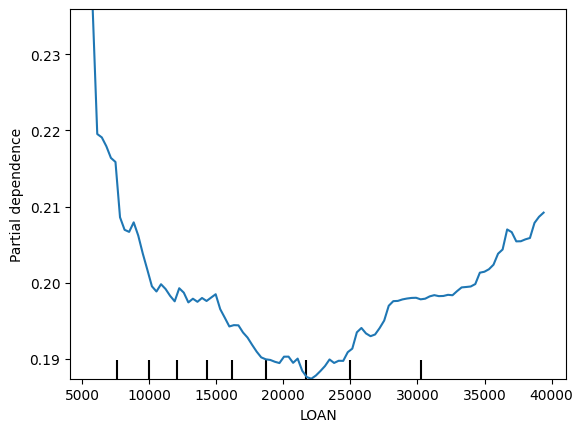

In [9]:
# Partial dependence of LOAN: use the function PartialDependenceDisplay from sklearn.inspection
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rf, X_train, features=['LOAN'])
plt.show()


**How to read this plot:** <br>
This plot depicts:
- the  selected feature on the x-axis
- the partial dependence/ effect of the selected feature on the outcome
- the deciles of the distribution of the feature (bars on the x-axis)

The PDP clearly augments our understanding of how the RF classifier uses the information in LOAN when calculating predictions. First, the PDP confirms that the predicted probability of default changes with LOAN, meaning that the feature is important. Further, the PDP suggests that the relationship between LOAN and the target is nonlinear, and roughly displays a U-shape. Lower values of LOAN result in higher predictions, but higher values of LOAN also cause higher predictions. Average LOAN amounts, for example in the range [15000 to 25000] give the lowest predictions. Compare this finding to a hypothetical PDP of a logistic regression model. The latter would show a linear relationship between LOAN and the target, as logistic regression can only estimate linear relationships.

It is obvious that the estimated marginal effect is nonlinear. Less obvious is what, specifically, the y-axis depicts. Above we said *predictions*. This is correct, but inaccurate. What the y-axis depicts depends on the type of prediction model. Here, we face a classification model. Classification models produce probability predictions. Then, the y-axis of the PDP shows the predicted probability $\hat{p}(Y=1|X)$, and how it changes with changes in the feature values when averaging out the effect of other features. For a regression model, on the other hand, the y-axis would simply depict the predictions of the target, that is $\hat{Y}$. 

A risk with PDP analysis is **extrapolation**. The model has estimated the feature-to-target relationship based on the training data. Intuitively, the reliability of this estimate should be good in regions of the feature distribution where there was a lot of training data. Likewise, feature values that only appeared sparsely in the training data, such as very small or large values, may not have allowed reliable estimation of the feature-to-target relationship. This is why the PDP shows the deciles of the feature distribution on the x-axis. In case you wondered, these are the little bars on the x-axis, which are sometimes called *rugs*. They indicate the first to ninth decile of the feature distribution. If needed, you can adjust the percentiles that the function is considering by setting the parameter `percentiles` in the call `PartialDependenceDisplay.from_estimator()`. Although the rugs offer some guidance, it can be useful to augment the analysis of the PDP with a visualization of the  feature distribution, for example by means of a histogram, to know more precisely which regions of the feature values have a lot or very little support in the training data. 

Another, perhaps more severe, risk with the interpretation of a PDP concerns the fact that our interpretation holds for the **predictions** of the RF. The PDP only shows how RF predictions change with a feature. This is very different from showing how actual target values change with a feature. 

To check your understanding of the PDP, answer the following questions:
- what would a PDP look like for a feature that has no effect on the target?
- what would a PDP look like for a feature that has a linear effect on the target?
- what would a PDP look like for a feature that has a nonlinear effect on the target when you use logistic regression?



In terms of functionality, `sklearn` has certainly a lot more to offer then creating a univariate PDP. The official [function description](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html) and [sklearn documentation](https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence) offer many additional insights and examples. Let's sketch one such example, an extension of the PDP to display not the model behavior as a whole but the development of predictions for every individual data point, i.e., every single borrower in our credit risk prediction context. This extension is known as the *ICE plot*, and is also supported by `PartialDependenceDisplay` by setting the argument `kind` to `individual` as follows.

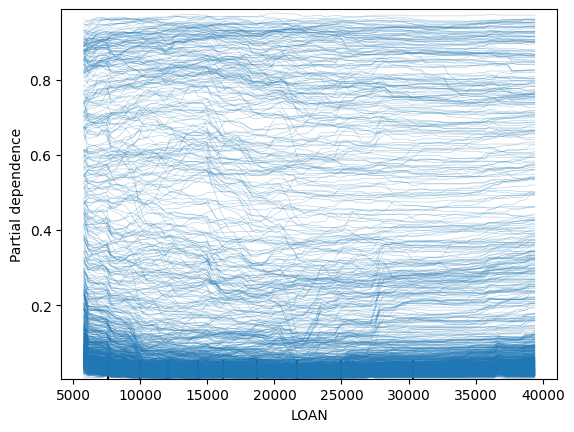

In [10]:
#Generate ICE plot:
PartialDependenceDisplay.from_estimator(rf, X_train, 
                                        features=['LOAN'], 
                                        feature_names=X.columns.values, 
                                        kind='individual');


Before moving on to local explanations, a quick comment on the `sklearn` implementation of the PDP. Just as with permutation-based importance, there are other packages that offer the same and sometimes more advanced functionalities. Our motivation to stick to `sklearn` is consistency. For example, the way different functions are used is very consistent and this make learning coding easier. In the context of PDP, a notable package is `pdpbox`, which some is said to provide better visualizations. Consider our above discussion on what the y-axis in a PDP actually depicts. A better annotation of the axis could avoid confusion. Try out `pdpbox` if interested and see whether you also find it to give better visualizations.

## Local Interpretability 
Techniques discussed up until here aim at interpreting a model at large. Therefore, they belong to the family of global interpretation methods. The lecture also introduced local interpretability and the SHAP framework. The following parts demonstrate this approach. 

Before moving on, please make sure to have the library installed on your machine. If needed, you could install it now using 
```bash
!pip install shap
```

### Shapley Additive Explanations

SHAP (SHapley Additive exPlanations) is a local, model-agnostic explanation method. The concept of the fair payout in a coalition, that is, the Shapley value, was introduced in the scope of cooperative game theory. The Shapley value captures the contribution a player makes to the outcome. <br> *When is this useful?* For example, if a football team wins a game that includes a cash price and wants to distribute this between the players based on their contribution to the result. <br> *How can we use this technique for model explanation?* In a machine learning context, our players are the features and the outcome is the prediction. So, we want to calculate the contribution of each feature to the prediction. <br>  *How is this achieved?* In a nutshell, this is done by changing the data slightly, and observing how the output changes, and then estimating how high each feature's contribution is to the prediction. Using SHAP values for interpretable machine learning was popularized by [Lundberg & Lee (2017)](https://papers.nips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html).

For this part of the demo notebook, we will use the [SHAP package](https://github.com/slundberg/shap) to apply this method. If you are interested in learning how to write this function from scratch, please follow [this link](
https://afiodorov.github.io/2019/05/20/shap-values-explained/) for a detailed explanation, or ask ChatGPT ;)

#### Calculate SHAP values
To calculate SHAP values, make use of the `shap.TreeExplainer`, which receives a prediction model (e.g., fitted sklearn model object) as input. More specifically, as the name states, this explainer accepts tree models as input and explains their prediction. It turns out that the computation of SHAP values is very costly. To cope with computational challenges, tailor-made ways to approximate the Shapley value for specific types of prediction models are needed. The `SHAP` library includes solutions for trees, neural networks, and a model agnostic approach, which is much slower than the other two (kindly refer to the [GitHub repositroy](https://github.com/slundberg/shap) for details). 

Whilst SHAP is a local explanation method, this package also facilitates calculating SHAP values for all observations and provides graphical summaries of the entire SHAP values distribution to allow for global interpretation. 

In [11]:
import shap 

# Explainer algorithm  for tree models
explainer = shap.Explainer(rf)

# Calculate SHAP values for all observations
# **** Note that this computation is costly and may take a while to run ****
shap_values = explainer(X_test)
print("Shape of result: {}".format(np.shape(shap_values)))  # some output to signal when done


Shape of result: (1788, 18, 2)


The dimensionality of the `shap_values` variable is informative. The first two dimensions correspond to the data we provided when computing the shap values via `shap_values = explainer(X_test)`. 

In [12]:
X_test.shape

(1788, 18)

However, the dimensionality shows that we have two SHAP values for each data point and feature.
```Python
shap_values.shape
(2, 1055, 18)
```
Why have them twice?

The answer lies in how RF produces predictions. From previous tutorials, you will recall that classification models can produce two forms of predictions, discrete class predictions (using `.predict()`) and probability predictions (using `.predict_proba()`). Further recall that the output of `.predict_proba()` is a 2D array comprising the estimated probabilities for class 0 (i.e., good risk) and class 1 (i.e., bad risk). The same concept applies to SHAP values. We receive them twice because our model predicts two classes. We can subset the array with the index 1, which gives us the  SHAP values for the probability predictions corresponding to class 1 (`shap_values_rf[1]`). This way, we focus on the prediction of the class default=1 or, differently put, bad payers. 

In [13]:
# Delete shap_values corresponding to class 0 predictions (redundant)
shap_values = shap_values[:,:,1]
shap_values.shape

(1788, 18)

### SHAP plots
The Shap framework provides a ton of visualizations to diagnose ML models. Some target local interpretability. Others aggregate the individual-level SHAP values to facilitate global interpretability. Below, we will consider some typical use cases and illustrate the way in which they are supported by SHAP. 


We start with the *waterfall* plot. It belongs to the functions targeting local interpretability. Therefore, we first choose a specific observation for inspection. Feel free to change the corresponding variable `test_point` to explore a different observation. You might want to take a look at the observation with index 852.

In [14]:
# Chose row/ observation and extract values
test_point = 2

In [15]:
shap_values[test_point]

.values =
array([ 6.54853599e-03,  9.64062514e-05,  8.29097373e-03,  7.81092455e-03,
        6.98683035e-02,  1.35007484e-01, -9.15379604e-04, -1.61792499e-02,
       -5.71472253e-04,  1.40200726e-03,  5.43533846e-03,  1.15834204e-03,
       -2.66407888e-03, -6.35938333e-04, -7.46004777e-03, -1.45839545e-02,
       -1.82745960e-02, -7.94280996e-02])

.base_values =
0.19894103547459252

.data =
array([1.53000000e+04, 5.78400000e+04, 8.69030000e+04, 0.00000000e+00,
       1.10827224e+02, 4.00000000e+00, 1.10000000e+01, 3.88261775e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

#### Waterfall plot

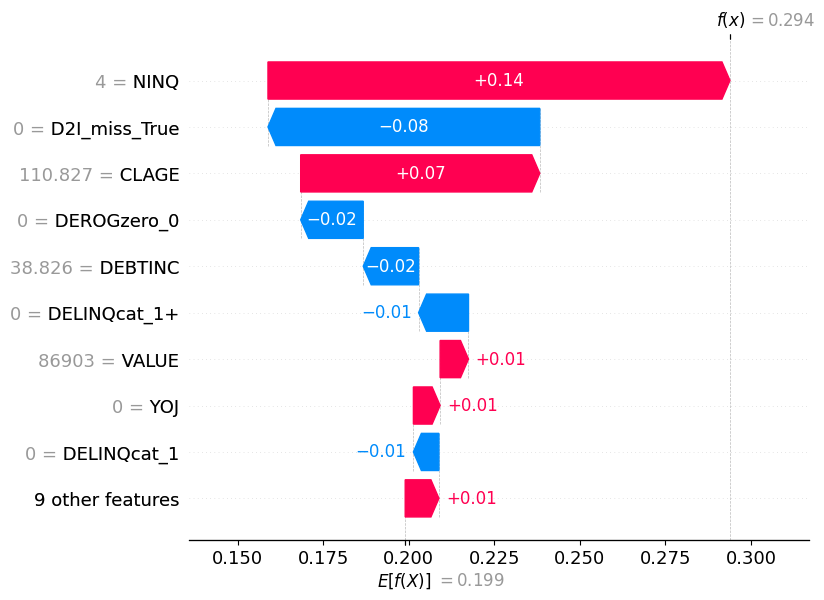

In [16]:
# Local explanation SHAP plot for RF model for a specific test point:
shap.initjs()
shap.plots.waterfall(shap_values[test_point])

## Exercise 4
To deepen your understanding of SHAP and the waterfall plot, perform the following tasks:
1. Write code to reproduce the value shown above the plot for *f(x)* using the trained random forest model `rf` and the test data `X_test`
2. Write code to reproduce the value shown below the plot for *E[f(x)]*
3. Write code to extract the SHAP value for the feature value *D2I_miss_True*. Print out the value with five digits of precision

**Optional tasks (challenging)**:
Create a bar plot that shows the SHAP values for the features that the above plot leaves out (i.e., aggregates in the entry *other features*)

In [17]:
# reproduce the value shown above the plot for *f(x)* 
yhat = rf.predict_proba(X_test)[test_point,1]
print(f'Model prediction for data point {test_point} equals {yhat:.3f}')

# reproduce the value shown below the plot for *E[f(x)]*
base_rate = np.sum(y_test)/len(y_test)
print(f'Prior probability of the class in the data (aka base rate) equals {base_rate:.3f}')

# Extract the SHAP value for the feature value *D2I_miss_True*.
ix = X_test.columns.get_loc("D2I_miss_True")  # find the column number of the feature
val = shap_values.values[test_point, ix]  # index the SHAP values
print(f'SHAP value of D2I_miss_True is {val:.5f}')


Model prediction for data point 2 equals 0.294
Prior probability of the class in the data (aka base rate) equals 0.200
SHAP value of D2I_miss_True is -0.07943


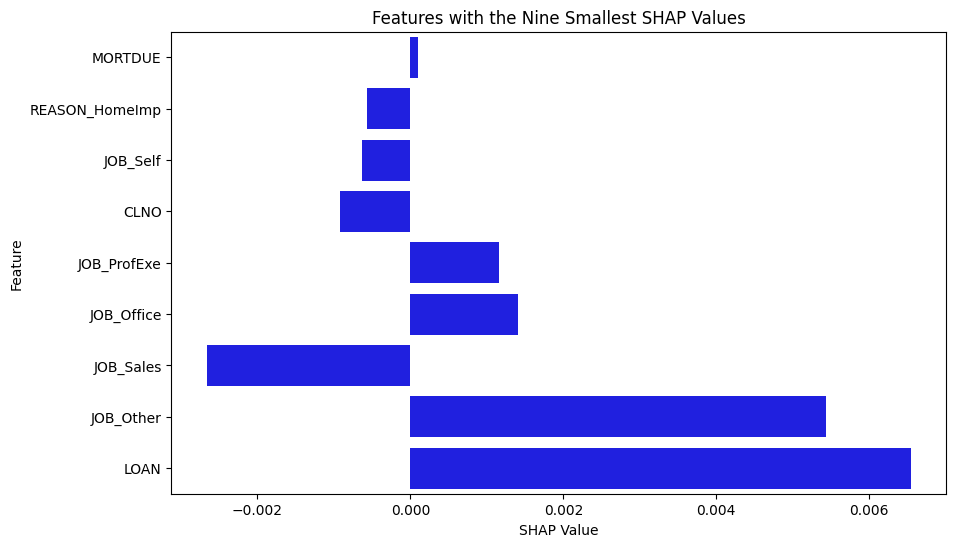

In [18]:
# Solution to the optional task:

# Extract the SHAP values for the test point
shap_values_test_point = shap_values[test_point]

# Get the indices of the nine smallest SHAP values
smallest_shap_indices = np.argsort(np.abs(shap_values_test_point.values))[:9]

# Get the corresponding feature names and SHAP values
smallest_shap_features = X_test.columns[smallest_shap_indices]
smallest_shap_values = shap_values_test_point.values[smallest_shap_indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=smallest_shap_values, y=smallest_shap_features, color='blue')
plt.title('Features with the Nine Smallest SHAP Values')
plt.xlabel('SHAP Value')
plt.ylabel('Feature')
plt.show()

An alternative visualization serving the same purpose is the *force plot*



#### Force plot

In [19]:
#Generate a force plot for a specific test data point:
shap.initjs()
shap.plots.force(shap_values[test_point])

In [20]:
# Generate a force plot for the first 100 data points:
shap.initjs()
shap.plots.force(shap_values[:100])

#### SHAP plots for global interpretability
The SHAP library also featuers plots that mimic the approach taken by the global explanation methods discussed in the previous section. For example, to shed light on global feature importance, we can plot the SHAP values of every feature for every data point. The plot, called `beeswarm` plot, sorts features by the sum of SHAP value magnitudes over all data points, which gives a measure of a feature's overall influence on predictions. The color represents the feature value (red high, blue low). This reveals for example that higher values of DEBTINC increase predicted default risk. 

If you find this output confusing, you can simplify the plot by taking the man absolute value of the SHAP values for each feature, which yields an ordinary bar plot; exactly as in the case of permutation-based feature importance.  

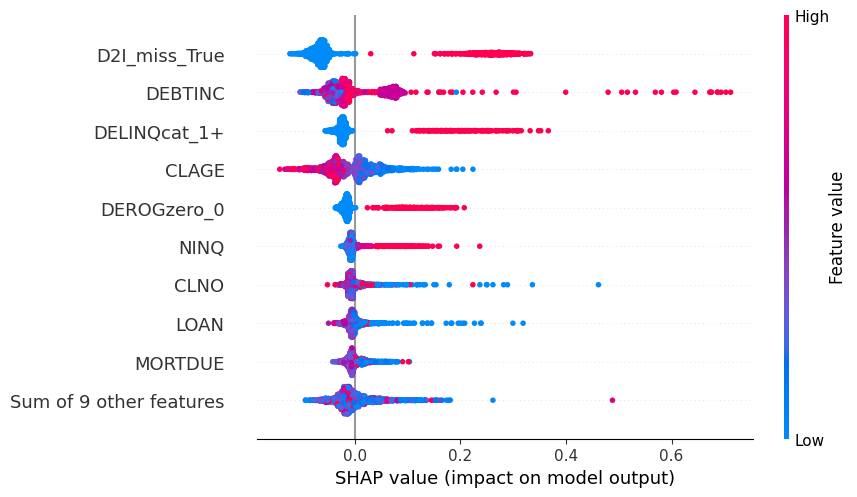

In [21]:
# SHAP-based feature importance analysis 
shap.initjs()
shap.plots.beeswarm(shap_values)

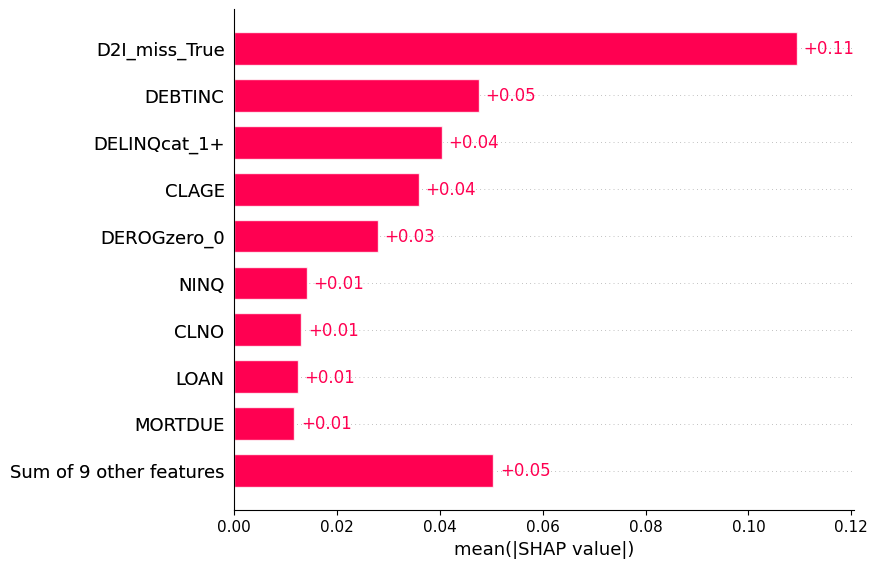

In [22]:
# SHAP-based feature importance analysis simplified
shap.initjs()
shap.plots.bar(shap_values)

In a similar way, SHAP can also mimic the analysis of partial dependence and shed light on a feature's effects on model predictions. To that end, we plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. By design, SHAP values embody the possible *coalitions* (i.e.,feature subsets) to which a feature can contribute information. In this regard, the marginalization of other features' effect, which is instrumental to PDP analysis, has already been taken into account when computing the SHAP values. Hence, SHAP values already represent a feature's responsibility for a change in model predictions and we can simply plot feature values against SHAP values (instead of predictions as in the case of the PDP). We showcase this approach for DEBTINC below.

Vertical dispersion at a single value of DEBTINC represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument, the scatter plot will pick the best feature to color by. In this case it picks NINQ.

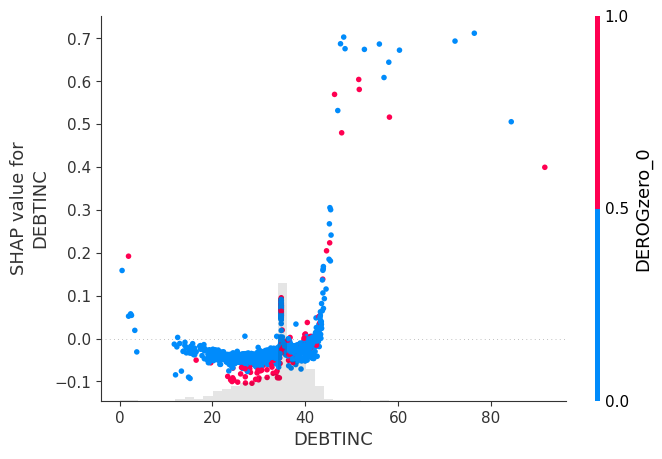

In [23]:
# SHAP-based dependence analysis 
shap.initjs()
shap.plots.scatter(shap_values[:, "DEBTINC"], color=shap_values)

The SHAP package provides additional visualization. Overall, the SHAP package offers a powerful framework for global and local model interpretation and has become a quasi-standard industry. 

While this notebook did not involve many programming tasks, we hope that you found our focus on demonstrating the many XAI concept covered in the lecture useful. By today, XAI is still an emerging field and there is no single best solution available. In this regard, demonstrating the space of options will, hopefully, benefit your further work in machine learning and AI. 

## Exercise 5
We focused on RF up to this point. Having seen many demos, you next task is train an XGB classifier for the same data and repeat the XAI analysis. This will give you a sense of how different models can lead to different insights. Begin with assessing global feature importance of an XGB model using i) permuation-based feature importance and ii) a suitable, corresponding approach based on SHAP values. Afterwards, go on to explore other techniques we discussed above. For example, compare how the RF and your XGB predict a specific credit applicant.


In [24]:
# Solutions to Exercise 5
# It is a good exercise to perform the tasks on your own. All relevant codes are included in this notebook, except codes to train an XGB model, which is available in a previous notebook.


# Well done! You made it to the end of another comprehensive demo.